## Automated Tree Cover Loss QC

In [1]:
import os
import math
import numpy as np
import rasterio as rio
import fiona
import pandas as pd
from utils import parse_bounds, concatenate_windows
from tqdm.notebook import tqdm
from rasterio.windows import from_bounds
from rasterstats import zonal_stats
from matplotlib import pyplot as plt

In [2]:
# data config
DATA_DIR = '../test'
OUT_DIR = '../output'
SHP_FN = 'kankan.shp'
treecover_threshold = 30

shp_fp = os.path.join(DATA_DIR, SHP_FN)

#### Get admin area bounds

Use bounds to read a window containing the admin zone from raster tiles

In [3]:
with fiona.open(shp_fp) as src:
    bounds = src.bounds
bounds

(-10.909955024719181, 8.7642440795899, -7.947204113006595, 12.502631187439029)

In [4]:
X_list, Y_list = parse_bounds(bounds)
X_list, Y_list

(['020W', '010W'], ['10N', '20N'])

#### Threshold tree cover density

Generate binary mask array from the tree cover density tile

In [5]:
tcd_arrs = []
for Y in Y_list:
    for X in X_list:
        with rio.open(f's3://gfw-data-lake/umd_tree_cover_density_2000/v1.6/raster/epsg-4326/10/40000/percent/geotiff/{Y}_{X}.tif') as src:
            window = from_bounds(
                bounds[0],
                bounds[1],
                bounds[2],
                bounds[3],
                src.transform
            )
            tcd_arrs.append(src.read(1, window=window))
            win_affine = src.window_transform(window)
            
            print(f'Extracted window for {Y}, {X}')

Extracted window for 10N, 020W
Extracted window for 10N, 010W
Extracted window for 20N, 020W
Extracted window for 20N, 010W


In [6]:
tcd_arr = concatenate_windows(tcd_arrs, X_list, Y_list)

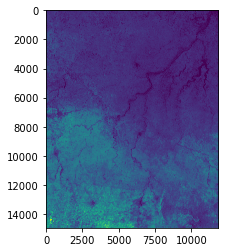

In [7]:
plt.imshow(tcd_arr)

In [8]:
# reclassify using binary threshold
tcd_arr_mask = tcd_arr.copy()
tcd_arr_mask[np.where( tcd_arr <= treecover_threshold )] = 0
tcd_arr_mask[np.where( tcd_arr > treecover_threshold )] = 1

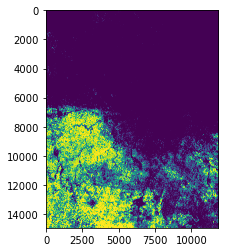

In [9]:
plt.imshow(tcd_arr_mask)

#### Set area array

Read area array and mask by tree cover density threshold

In [10]:
area_arrs = []
for Y in Y_list:
    for X in X_list:
        with rio.open(f's3://gfw-files/2018_update/area/{Y}_{X}.tif') as src:
            area_arr = src.read(1, window=from_bounds(
                bounds[0],
                bounds[1],
                bounds[2],
                bounds[3],
                src.transform
            ))
        area_arrs.append(area_arr)
        
        print(f'Extracted window for {Y}, {X}')

Extracted window for 10N, 020W
Extracted window for 10N, 010W
Extracted window for 20N, 020W
Extracted window for 20N, 010W


In [11]:
area_arr = concatenate_windows(area_arrs, X_list, Y_list)

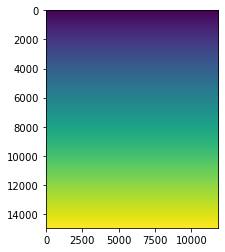

In [12]:
plt.imshow(area_arr)

In [13]:
# mask by treecover threshold array
area_mask = np.multiply(tcd_arr_mask, area_arr)

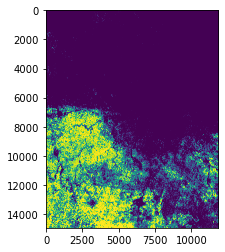

In [14]:
plt.imshow(area_mask)

#### Mask tree cover loss

Read tree cover loss from window and mask using tree cover density threshold

In [15]:
# read as np array from bounds
tcl_arrs = []
for Y in Y_list:
    for X in X_list:
        with rio.open(f's3://gfw-data-lake/umd_tree_cover_loss/v1.7/raster/epsg-4326/10/40000/year/geotiff/{Y}_{X}.tif') as src:
            tcl_arr = src.read(1, window=from_bounds(
                bounds[0],
                bounds[1],
                bounds[2],
                bounds[3],
                src.transform
        ))
        
        tcl_arrs.append(tcl_arr)
        print(f'Extracted window for tree cover loss tile: {Y}, {X}')

Extracted window for tree cover loss tile: 10N, 020W
Extracted window for tree cover loss tile: 10N, 010W
Extracted window for tree cover loss tile: 20N, 020W
Extracted window for tree cover loss tile: 20N, 010W


In [16]:
tcl_arr = concatenate_windows(tcl_arrs, X_list, Y_list)

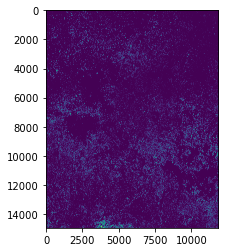

In [17]:
plt.imshow(tcl_arr)

In [18]:
# mask tree cover loss by treecover threshold
tcl_masked = np.multiply(tcd_arr_mask, tcl_arr)

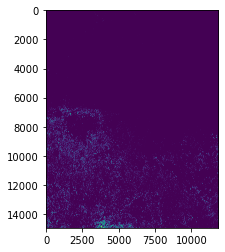

In [19]:
plt.imshow(tcl_masked)

#### Compute zonal statistics for admin boundary

In [20]:
loss_by_year_ha = {}

for year in tqdm(range(1,20)):
    
    # copy thresholded tree cover loss array
    tcl_arr_year = tcl_masked.copy()
    
    # mask by current year
    tcl_arr_year[np.where( tcl_masked != year )] = 0
    tcl_arr_year[np.where( tcl_masked == year )] = 1
    
    # convert to ha using area mask
    tcl_arr_year_area = np.multiply(area_mask, tcl_arr_year) / 10000
    
    # compute zonal stats for admin area
    zstats = zonal_stats(
        shp_fp,
        tcl_arr_year_area,
        stats='sum',
        affine=win_affine,
        all_touched=True,
        nodata=-999
    )
    
    # log
    annual_loss = zstats[0]['sum']
    print(f'TCL in {year + 2000}: {int(annual_loss)} ha')
    loss_by_year_ha[year + 2000] = annual_loss

TCL in 2001: 1640 ha
TCL in 2002: 3252 ha
TCL in 2003: 1574 ha
TCL in 2004: 3787 ha
TCL in 2005: 1915 ha
TCL in 2006: 1661 ha
TCL in 2007: 5805 ha
TCL in 2008: 5501 ha
TCL in 2009: 3132 ha
TCL in 2010: 4419 ha
TCL in 2011: 2961 ha
TCL in 2012: 1657 ha
TCL in 2013: 5551 ha
TCL in 2014: 5405 ha
TCL in 2015: 6160 ha
TCL in 2016: 8997 ha
TCL in 2017: 13267 ha
TCL in 2018: 11179 ha
TCL in 2019: 13621 ha



#### Save as CSV

In [21]:
loss_df = pd.DataFrame.from_dict(loss_by_year_ha, orient='index')
loss_df = loss_df.rename(columns={0:'area_ha'})
loss_df['threshold'] = f'{treecover_threshold}%'

In [22]:
loss_df.to_csv(os.path.join(
    OUT_DIR, 
    f'{SHP_FN[:-4]}_tree_cover_loss_ha.csv'),
    index_label='year'
)

In [23]:
loss_df

,area_ha,threshold
2001,1640.780100,30%
2002,3252.003700,30%
2003,1574.247720,30%
2004,3787.836747,30%
2005,1915.638751,30%
2006,1661.089579,30%
2007,5805.457071,30%
2008,5501.213658,30%
2009,3132.514928,30%
2010,4419.618374,30%
